# Physics-Informed Neural Network (PINN)


## Problem overview

<div align="center">
  <a href="https://de.wikipedia.org/wiki/Mathematisches_Pendel#:~:text=Mathematisches%20Pendel.%20Das%20mathematische%20Pendel%20oder%20ebene%20Pendel,schwingen%2C%20wobei%20Reibungseffekte%2C%20insbesondere%20der%20Luftwiderstand%20vernachl%C3%A4ssigt%20werden.">
    <img src="https://upload.wikimedia.org/wikipedia/commons/3/3a/Kraefte_am_Fadenpendel_gro%C3%9F.svg" 
    alt="Images" width="200">
  </a>
</div>

$$
\ddot \theta + \frac{\delta}{m l^2} \cdot \dot \theta + \frac{g}{l} \cdot \sin(\theta)  = 0~,
$$

$$
\theta_0 = 3.14~[rad]~~,~~\dot \theta_0 = 0~[\frac{rad}{s}]~.
$$

## Workflow


> * Symbolische Herleitung (**`sympy`**) der Bewegungsgleichung des freien, gedämpften Pendels nach Legrange mit.

> * Numerische Lösung der DGL mit Hilfe von **`scipy.itegrate.odeint`**.

> * Trainingspunkte, die eine reale Messung ersetzen, aus numerischer Lösung extrahieren.

> * Interpolation der Punkte mit Hilfe eines Neuronales Netzes.

> * Training eines PINNs, um den Bewegungsablauf ausßerhalb der Trainingspunkte anzunähern, indem DGL in die Loss-Funktion eingebettet wird.


### Environment set up

Sollten Fehlermeldungen erscheinen, obwohl alle benötigten Module installiert sind, hilft es wohlmöglich eine virtuelle Umgebung für das Arbeiten mit PINNs einzurichten:
```bash
conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```
```
conda install scipy, sympy
```

#### Activate Enviroment in cmd
```bash
conda activate pinn
jupyter notebook 
```

## Credits:
Das Problem des gedämpften Einmassenschwingers ([benmoseley](https://github.com/benmoseley/harmonic-oscillator-pinn)) wurde an das mathematische Pendel angepasst.

## Herleitung der DGL

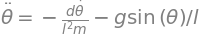

In [1]:
import sympy as smp
import sympy.physics.mechanics as mech
mech.init_vprinting()

# symbolische Herleitung der DGL
t, g, l, m, d = smp.symbols('t, g l m d')

theta = smp.Function('theta')(t)
theta_d = theta.diff(t)
theta_dd = theta_d.diff(t)

T = smp.Rational(1,2) * m * (l * theta_d)**2
V = m * g * (- l * smp.cos(theta))
L = T - V

LE = smp.diff(smp.diff(L, theta_d) ,t) - smp.diff(L, theta)
LE = smp.Eq(LE, -d * theta_d)

solution = smp.solve(LE, theta_dd)
display(smp.Eq(theta_dd, solution[0]))

# symbolic --> numeric computeable
dthetadt = smp.lambdify(theta_d, theta_d)
domegadt = smp.lambdify((t, theta, theta_d, g, l, m, d), solution[0])

def dSdt(S, t, g, l, m, d):
    theta, omega = S
    return [
        dthetadt(omega),
        domegadt(t, theta, omega, g, l, m, d)
    ]

## Generate training data

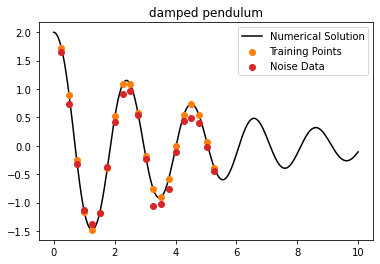

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interpolate

# Zeitbereich
t1 = 10
frames = 200
t = np.linspace(0,t1,frames)


l = 1.0
d = 0.4
m = 1.0
g = 9.81

S0 = [2.0, 0.0]

solution = odeint(dSdt, y0=S0, t=t, args=(g, l, m, d))
theta = solution[:,0]


theta_solution = interpolate.interp1d(t, theta, 'cubic') # Lösungsfunktion (für DeepXDE solution)


# Messpunkte aus Lösung generieren
# jeden 10. Messpunkt im Bereich [20-100]
t_data = t[5:110:5] 
theta_data = theta[5:110:5]
theta_data_noise = theta_data + np.random.normal(-0.1, 0.1, len(theta_data))

# theta über t
fig = plt.figure(111)
plt.title('damped pendulum')

plt.plot(t, theta, '-k', label="Numerical Solution")
plt.scatter(t_data, theta_data, color="tab:orange", label="Training Points", zorder=3)
plt.scatter(t_data, theta_data_noise, color="tab:red", label="Noise Data", zorder=3)

plt.legend()
plt.show()


# Array --> torch.Tensor 
theta = torch.Tensor(theta)
theta = theta.view(-1,1)
t = torch.Tensor(t).view(-1,1)

theta_data = torch.Tensor(theta_data).view(-1,1)
theta_data_noise = torch.Tensor(theta_data_noise).view(-1,1)
t_data = torch.Tensor(t_data).view(-1,1)

In [ ]:
import torch.nn as nn

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def plot_result(x,y,x_data,y_data,yh,xp=None):
    
    "Pretty plot training results"
    figure = plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    x_max = torch.max(x)
    y_min = torch.min(y)
    y_max = torch.max(y)
    plt.xlim(-0.1, x_max*1.1)
    plt.ylim(y_min*1.1, y_max*1.1)
    plt.text(x_max*1.1, y_max*0.75, "Training step: %i"%(i+1), fontsize="xx-large", color="k")
    plt.axis("off")
    
    return figure

## Normal neural network

> Next, we train a standard neural network (fully connected) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

>"One popular way of doing this using machine learning is to use a neural network. Given the location of a data point as input (denoted x), a neural network can be used to output a prediction of its value (denoted u), as shown in the figure below." [Ben Moseley](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/)

<div align="center">
  <a href="https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/">
    <img src="https://benmoseley.blog/wp-content/uploads/2021/08/nn.png" 
    alt="Images" width="600">
  </a>
</div>

> To learn a model, we try to tune the network’s free parameters (denoted by the \thetas in the figure above) so that the network’s predictions closely match the available experimental data. This is usually done by minimising the mean-squared-error between its predictions and the training points;

>The problem is, using a purely data-driven approach like this can have significant downsides. Have a look at the actual values of the unknown physical process used to generate the experimental data in the animation above (grey line).

>You can see that whilst the neural network accurately models the physical process within the vicinity of the experimental data, it fails to generalise away from this training data. By only relying on the data, one could argue it hasn’t truly “understood” the scientific problem.

In [ ]:
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []

episodes = 4000

for i in range(episodes):
    optimizer.zero_grad()
    
    #theta_prediction --> theta_p
    theta_p = model(t_data)
    loss = torch.mean((theta_p - theta_data)**2) # mean squared error
    loss.backward() # Gradient berechnen
    optimizer.step() # Backpropagation
    
    
    # plot the result as training progresses
    if (i+1) % (round(episodes/25)) == 0: 
        
        theta_p = model(t).detach()
        
        plot_result(t,theta,t_data,theta_data,theta_p)
        
        file = "plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % episodes == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("Pendulum_NN.gif", files, fps=10, loop=0)

## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain. We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch`'s autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

<div align="center">
  <a href="https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/">
    <img src="https://benmoseley.blog/wp-content/uploads/2021/08/pinn.png" 
    alt="Images" width="600">
  </a>
</div>





>One way to do this for our problem is to use a physics-informed neural network [1,2]. The idea is very simple: add the known differential equations directly into the loss function when training the neural network.

>This is done by sampling a set of input training locations (\{x_{j}\}) and passing them through the network. Next gradients of the network’s output with respect to its input are computed at these locations (which are typically analytically available for most neural networks, and can be easily computed using autodifferentiation). Finally, the residual of the underlying differential equation is computed using these gradients, and added as an extra term in the loss function.

>The physics-informed neural network is able to predict the solution far away from the experimental data points, and thus performs much better than the naive network. One could argue that this network does indeed have some concept of our prior physical principles.

>The naive network is performing poorly because we are “throwing away” our existing scientific knowledge; with only the data at hand, it is like trying to understand all of the data generated by a particle collider, without having been to a physics class!

In [ ]:
import time

x_physics = torch.linspace(0,t1,t1*3).view(-1,1) # sample locations over the problem domain
x_physics.requires_grad_(True) # punkte sollen differenzierbar sein (für backpropagation)

# --> zeitpunkte an denen die prediction des netzes (theta --> Lösungsfunktion bzw. disktet = Lösungswert ) mit pde 
# verglichen wird (soll null sein, da ode nach 0 umgestellt werden muss)

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []

start = time.time()

episodes = 300

for i in range(episodes):
    optimizer.zero_grad()
    
    theta_p = model.forward(t_data)
    loss1 = torch.mean((theta_p-theta_data)**2) # gemittelter quadratischer fehler 
    
    # compute the "physics loss"
    # theta_physics_prediction --> theta_pp
    theta_pp = model.forward(x_physics)
    theta_pp_d  = torch.autograd.grad(theta_pp, x_physics, torch.ones_like(theta_pp), create_graph=True)[0]
    theta_pp_dd = torch.autograd.grad(theta_pp_d,  x_physics, torch.ones_like(theta_pp_d),  create_graph=True)[0]
    physics = theta_pp_dd + (d/m*l**2)*theta_pp_d + (g/l)*torch.sin(theta_pp) 
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2 # add two loss terms together
    #loss = loss2 # --> ergibt const 0
    loss.backward() # fehler nach dem input (zeit) ableiten
    optimizer.step() # fehler ins netz backpropagieren
    
    # plot the result as training progresses
    if (i+1) % (round(episodes/500)) == 0: 
        
        yh = model.forward(t).detach() # nimmt die pediction für den ganzen zeitbereich
        xp = x_physics.detach()
        
        plot_result(t,theta,t_data,theta_data,yh,xp)
        
        file = "plots/pendulum_pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % (round(episodes/5)) == 0: plt.show()
        else: plt.close("all")

duration = time.time() - start
print('duration: %s [s]' % round(duration))
            
#save_gif_PIL("Pendulum_PINN.gif", files, fps=15, loop=0)

# ab hier mit DEEPXDE

> Hi, Lulu!

>I am a beginner in this area. I am trying to modify the 'ode_system.py' to solve an ODE that describes a simple pendulum movement. I always got very large test metrics and it changed very slowly. Shall I need to add something or change the hyperparameter of the FNN?

>The following is my codes, hope you can give me some advice to improve it. Thank you in advance!

###### https://github.com/lululxvi/deepxde/issues/384

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term

Compiling model...
Building feed-forward neural network...
'build' took 0.038571 s



C:\Users\lenna\anaconda3\envs\pinn\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\lenna\anaconda3\envs\pinn\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.735417 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [8.93e+01, 4.96e-01]    [8.93e+01, 4.96e-01]    [2.03e+00]    
1000      [2.06e-01, 1.88e+00]    [2.16e+00, 1.88e+00]    [9.17e-01]    
2000      [4.07e-02, 3.92e+00]    [4.07e-02, 3.92e+00]    [9.99e-01]    
3000      [4.07e-02, 3.92e+00]    [4.07e-02, 3.92e+00]    [9.99e-01]    
4000      [4.07e-02, 3.92e+00]    [4.07e-02, 3.92e+00]    [9.99e-01]    
5000      [4.57e-02, 3.91e+00]    [4.57e-02, 3.91e+00]    [9.99e-01]    
6000      [2.69e-02, 3.93e+00]    [2.69e-02, 3.93e+00]    [9.99e-01]    
7000      [3.77e-02, 3.92e+00]    [3.77e-02, 3.92e+00]    [9.99e-01]    
8000      [3.82e-02, 3.92e+00]    [3.82e-02, 3.92e+00]    [9.99e-01]    
9000      [8.28e-02, 3.88e+00]    [8.28e-02, 3.88e+00]    [9.99e-01]    
10000     [3.99e-02, 3.92e+00]    [3.99e-02, 3.92e+00]    [9.99e-01]    
11000     [3.66e-02, 3.92e+00]    [3.66e-02, 3.92e+0

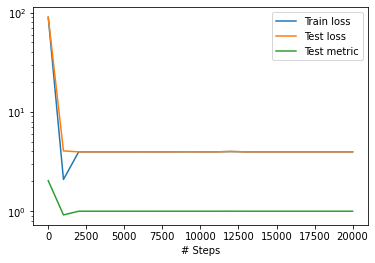

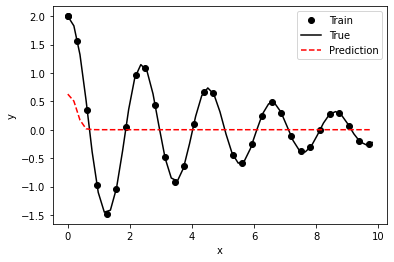

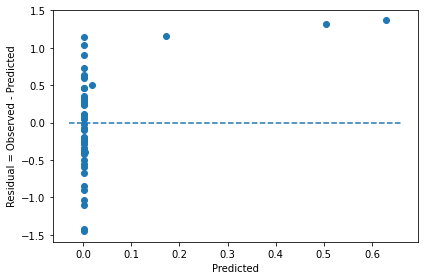

In [3]:
import deepxde as dde
import numpy as np
import tensorflow as tf

def ode_system(t, theta):
    """ODE
    theta''(t) = -g*sin(theta(t))/L
    """
    #dtheta1_dt = dde.grad.jacobian(theta, t, i=0)
    #dtheta2_dt = dde.grad.jacobian(dtheta1_dt, t, i=0)
    dtheta2_dt = dde.grad.hessian(theta, t, i=0)
    return [dtheta2_dt + (9.81/1)*tf.sin(theta)]

def boundary(_, on_initial):
    return on_initial

def func(t):
    """
    theta = cos(t)
    """
    return theta_solution(t)

geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.IC(geom, theta_solution, boundary, component=0)
data = dde.data.PDE(geom, ode_system, [ic1], 30, 1, solution=func, num_test=50) 

layer_size = [1] + [30] * 3 + [1]
activation = "sigmoid"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.1, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)